In [229]:
import argparse
import sys
import os
import json
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
from collections import Counter

/Users/katemarg/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [230]:
BASE_DIR = "/Users/katemarg/PycharmProjects/temporal_robustness_evaluation"
DATA_DIR = os.path.join(BASE_DIR, 'data')
CKPT_DIR = os.path.join(BASE_DIR, 'pretrained_models')
RES_DIR = os.path.join(BASE_DIR, 'results')
LOG_DIR = os.path.join(BASE_DIR, 'logs')
CACHE_DIR = os.path.join(BASE_DIR, 'cached')

In [232]:
# for full log open
# torch.load(os.path.join(RES_DIR, "full_results_twitter-roberta-base-mar2022_2019-Q2_deleted_100_5_1234.pt"))

In [236]:
filepath = "timelms_dynamic-templama_2019-1-1_to_2022-12-31_per_quarter_multi_token_1234_20_100_trial2.csv"
results_df = pd.read_csv(os.path.join(RES_DIR, filepath))

In [235]:
lts_df

,Unnamed: 0,model,dataset,quarter,size,split,P@1,P@10,P@20,P@50,P@100,same_pos,mrr,avg_f1_micro,avg_f1_macro,avg_rouge,avg_bleu,avg_bleu_uni,avg_bert_score
0,0,cardiffnlp/twitter-roberta-base-mar2022,dynamic-templama,2019-Q2,198,new,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0667,0.040,0.0667,0.0,0.0667,0.8787
1,1,cardiffnlp/twitter-roberta-base-mar2022,dynamic-templama,2019-Q2,36,updated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,0.0444,0.0,0.0400,0.8866
2,2,cardiffnlp/twitter-roberta-base-mar2022,dynamic-templama,2019-Q2,206,deleted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,0.0000,0.0,0.0000,0.8895
3,3,cardiffnlp/twitter-roberta-base-mar2022,dynamic-templama,2019-Q3,313,new,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,0.1600,0.0,0.1333,0.8730
4,4,cardiffnlp/twitter-roberta-base-mar2022,dynamic-templama,2019-Q3,65,updated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0400,0.025,0.1943,0.0,0.2000,0.8902
5,5,cardiffnlp/twitter-roberta-base-mar2022,dynamic-templama,2019-Q3,264,deleted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,0.0000,0.0,0.0000,0.8888


# Results with single-token only for TempLAMA 
- `TimeLMs`: Twitter-based RoBERTa models trained quarterly from Dec 2019 until Mar 2022
- `TempLAMA`: test set of 9 facts (templates) that change across time (yearly from 2010 to 2020)

In [237]:
# results_df = pd.read_csv(os.path.join(RES_DIR, "timelms_dynamic-templama_2019-1-1_to_2022-12-31_per_quarter_single_mask.csv"))
# results_df = pd.read_csv(os.path.join(RES_DIR, "timelms_templama_single_mask_results.csv"))
results_df['model'] = results_df['model'].apply(lambda x: x.split('-')[-1])
results_df.loc[results_df['model'] == "90m", 'model'] = "2019-Q4"
results_df.loc[results_df['model'] == "mar2020", 'model'] = "2020-Q1"
results_df.loc[results_df['model'] == "jun2020", 'model'] = "2020-Q2"
results_df.loc[results_df['model'] == "sep2020", 'model'] = "2020-Q3"
results_df.loc[results_df['model'] == "dec2020", 'model'] = "2020-Q4"
results_df.loc[results_df['model'] == "mar2021", 'model'] = "2021-Q1"
results_df.loc[results_df['model'] == "jun2021", 'model'] = "2021-Q2"
results_df.loc[results_df['model'] == "sep2021", 'model'] = "2021-Q3"
results_df.loc[results_df['model'] == "dec2021", 'model'] = "2021-Q4"
results_df.loc[results_df['model'] == "mar2022", 'model'] = "2022-Q1"

In [238]:
results_df

,Unnamed: 0,model,dataset,quarter,size,split,P@1,P@10,P@20,P@50,P@100,same_pos,mrr,avg_f1_micro,avg_f1_macro,avg_rouge,avg_bleu,avg_bleu_uni,avg_bert_score
0,0,2022-Q1,dynamic-templama,2019-Q2,198,new,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0667,0.040,0.0667,0.0,0.0667,0.8787
1,1,2022-Q1,dynamic-templama,2019-Q2,36,updated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,0.0444,0.0,0.0400,0.8866
2,2,2022-Q1,dynamic-templama,2019-Q2,206,deleted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,0.0000,0.0,0.0000,0.8895
3,3,2022-Q1,dynamic-templama,2019-Q3,313,new,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,0.1600,0.0,0.1333,0.8730
4,4,2022-Q1,dynamic-templama,2019-Q3,65,updated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0400,0.025,0.1943,0.0,0.2000,0.8902
5,5,2022-Q1,dynamic-templama,2019-Q3,264,deleted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,0.0000,0.0,0.0000,0.8888


In [239]:
set(results_df["split"])

{'deleted', 'new', 'updated'}

In [200]:
# roberta_results_df = pd.read_csv(os.path.join(RES_DIR, "roberta-base_roberta-large_templama_single_mask_new_new.csv"))
# roberta_results_df_4years = roberta_results_df[roberta_results_df['year']>=2018]

In [201]:
# df_all = roberta_results_df.append(results_df, ignore_index=True)

### The task is Masked Language Modeling (MLM) / Fill-Mask and the evaluation metric is P@k.

In [210]:
def boxplot_vis(label, df):
    sns.barplot(x='year', y=label, data=df, hue='model', palette="rocket")
    sns.despine(offset=10, trim=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title("TempLAMA / single token / {}".format(label))
    plt.xticks(rotation=45)
    plt.savefig('plots/{}_per_quarter.png'.format(label), bbox_inches = 'tight',edgecolor='white')

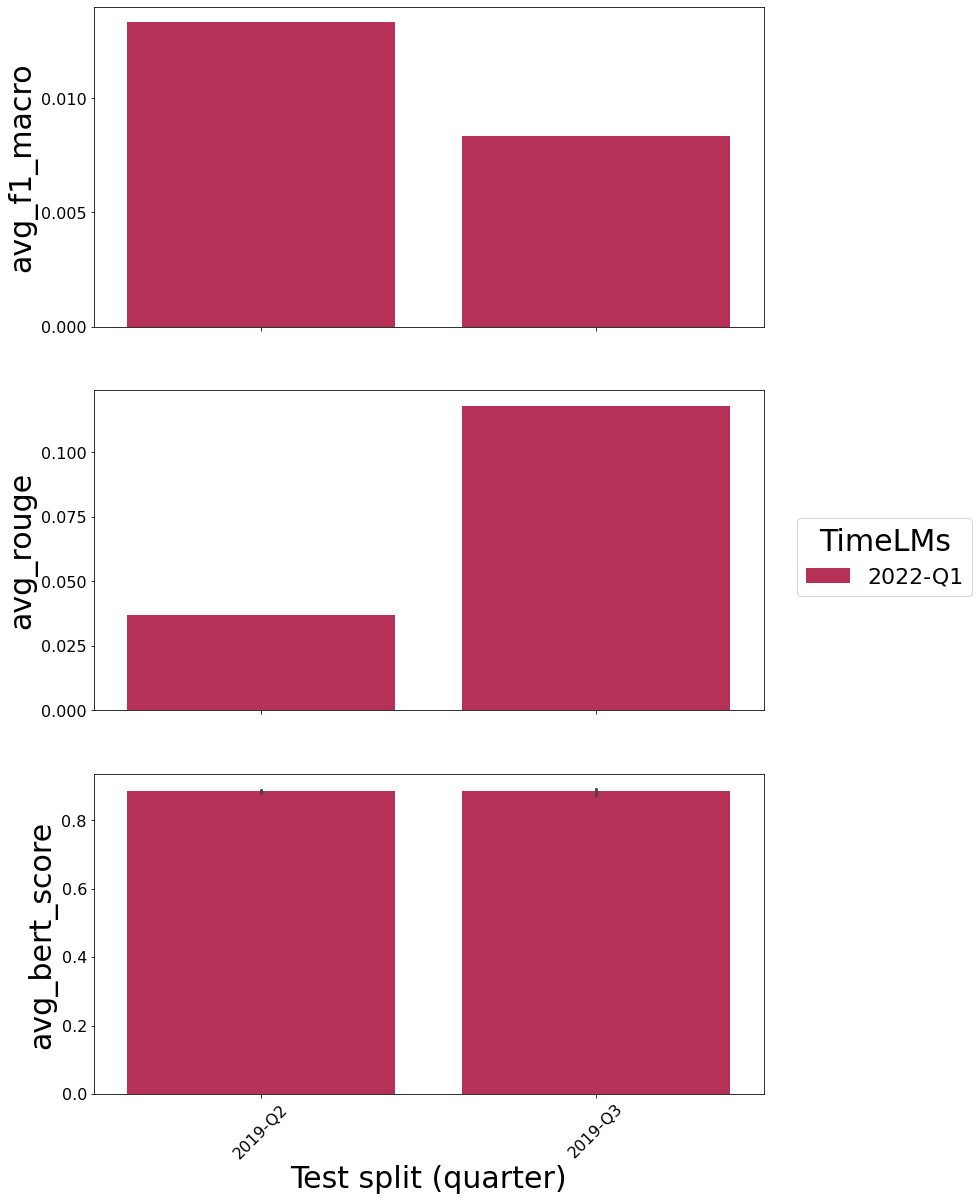

In [240]:
fig, axs = plt.subplots(3,1, figsize=(12, 20), sharex=True)
sns.barplot(x='quarter', y="avg_f1_macro", data=results_df, hue='model', palette="rocket", ax=axs[0], ci=None)
sns.barplot(x='quarter', y="avg_rouge", data=results_df, hue='model', palette="rocket", ax=axs[1], ci=None)
sns.barplot(x='quarter', y="avg_bert_score", data=results_df, hue='model', palette="rocket", ax=axs[2])
# sns.barplot(x='year', y="P@20", data=results_df, hue='model', palette="rocket", ax=axs[3])
# sns.barplot(x='year', y="P@50", data=results_df, hue='model', palette="rocket", ax=axs[4])
# sns.barplot(x='year', y="P@100", data=results_df, hue='model', palette="rocket", ax=axs[5])
[ax.get_legend().remove() for ax in axs[:-1]]
[ax.set_xlabel("") for ax in axs[:-1]]
axs[-1].set_xlabel("Test split (quarter)")
plt.legend(bbox_to_anchor=(1.05,1.8), loc='upper left', borderaxespad=0, prop={'size': 22}, title='TimeLMs')
for ax in axs:
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)
plt.rcParams.update({'font.size': 30})
plt.xticks(rotation=45)
plt.savefig('plots/P@k_quarters_all_models.png', bbox_inches = 'tight',edgecolor='white',dpi=500)
# plt.show()

In [241]:
list(set(results_df['split']))

['deleted', 'new', 'updated']

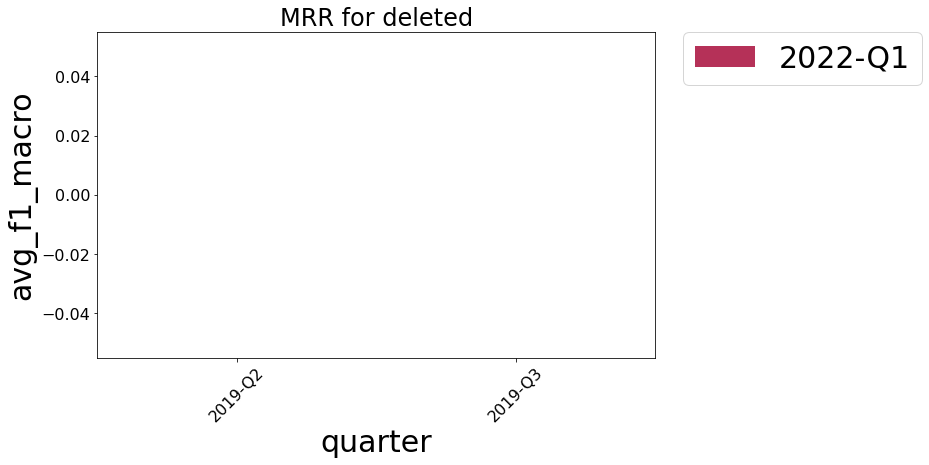

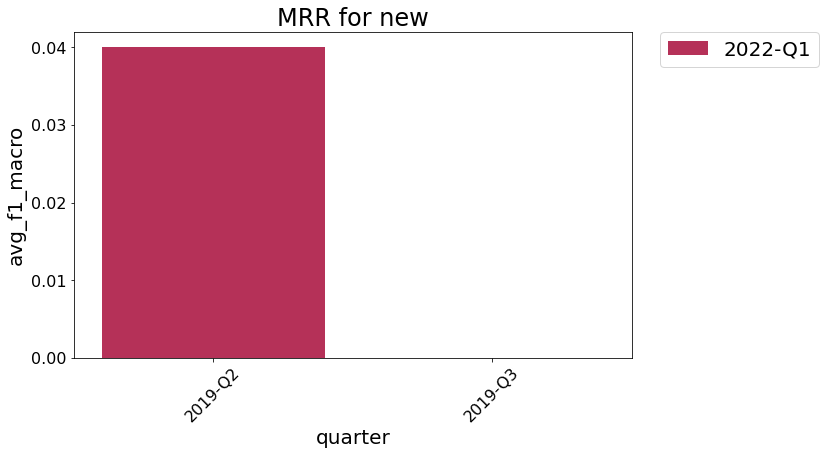

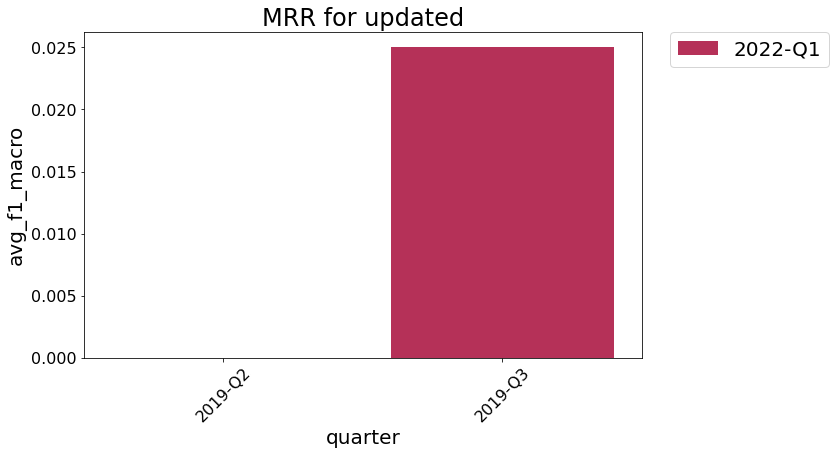

In [244]:
for split in list(set(results_df['split'])):
    _df = results_df[results_df['split']==split]
    fig, axs = plt.subplots(1,1, figsize=(10, 6), sharex=True)
    axs = [axs]
    # sns.barplot(x='year', y="P@1", data=results_df, hue='model', palette="rocket", ax=axs[0])
    sns.barplot(x='quarter', y="avg_f1_macro", data=_df, hue='model', palette="rocket")
    # sns.barplot(x='year', y="P@20", data=results_df, hue='model', palette="rocket", ax=axs[2])
    # sns.barplot(x='year', y="P@50", data=results_df, hue='model', palette="rocket", ax=axs[3])
    # sns.barplot(x='year', y="P@100", data=results_df, hue='model', palette="rocket", ax=axs[4])
    # [ax.get_legend().remove() for ax in axs[:-1]]
    # [ax.set_xlabel("") for ax in axs[:-1]]
    # axs[4].set_xlabel("Test split (year)")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0, )
    for ax in axs:
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(16)
    plt.rcParams.update({'font.size': 20})
    plt.xticks(rotation=45)
    plt.title("MRR for {}".format(split))
    plt.savefig('plots/MRR_quarters_all_models_{}.png'.format(split), bbox_inches = 'tight',edgecolor='white',dpi=500)

In [147]:
# boxplot_vis("P@1", results_df)

In [148]:
# boxplot_vis("P@1", last_4_years_df)

In [149]:
# boxplot_vis("P@10", last_4_years_df)

In [150]:
# boxplot_vis("P@20", last_4_years_df)

In [151]:
# boxplot_vis("P@50", last_4_years_df)

In [152]:
# boxplot_vis("P@100", last_4_years_df)

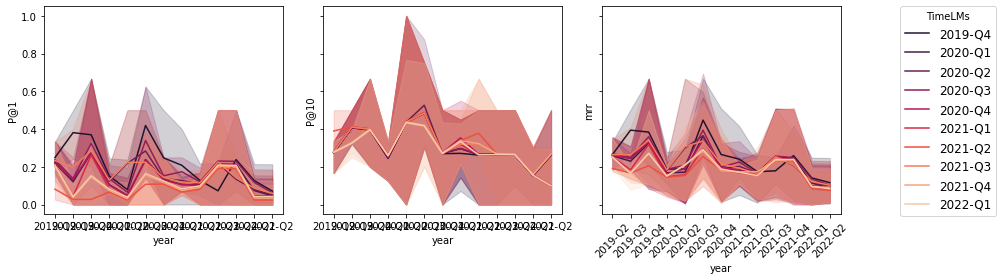

In [215]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14, 4), sharey=True)
sns.lineplot(
    data=results_df,
    x="year", 
    y="P@1",
    hue="model", 
    palette="rocket",
    ax=ax1,
    legend=False
)
ax2.set_ylabel("P@10")
sns.lineplot(
    data=results_df,
    x="year", 
    y="P@10",
    hue="model", 
    palette="rocket",
    ax=ax2,
    legend=False
)
ax3.set_ylabel("mrr")
sns.lineplot(
    data=results_df,
    x="year", 
    y="mrr",
    hue="model", 
    palette="rocket",
    ax=ax3
)
ax3.legend(bbox_to_anchor=(1.25, 1), loc='upper left', borderaxespad=0, title='TimeLMs', prop={'size': 12})
for ax in axs:
#     ax.tick_params(bottom='off')
    ax.tick_params(axis='x', rotation=45)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)
#     ax.tick_params(labelrotation=45)
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(45)
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.rcParams.update({'font.size': 10})
# plt.xticks(rotation = 45)
plt.xticks(rotation=45)
fig.tight_layout()
plt.savefig('plots/p_over_time_lineplot_quarter.png', bbox_inches = 'tight')

In [153]:
# fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8, 13), sharex=True)
# # sns.set_theme(style="ticks")
# sns.violinplot(data=df_all, y='P@1', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax1)
# sns.violinplot(data=df_all, y='P@10', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax2)
# sns.violinplot(data=df_all, y='P@20', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax3)
# plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# ax1.set_xlabel("")
# ax2.set_xlabel("")
# ax3.set_xlabel("TimeLM")
# ax1.set_title('P@k of different models *on average* across all time periods (2010-2022).')
# plt.savefig('plots/P@k_avg_time_allperiods.png', bbox_inches = 'tight', dpi=500)

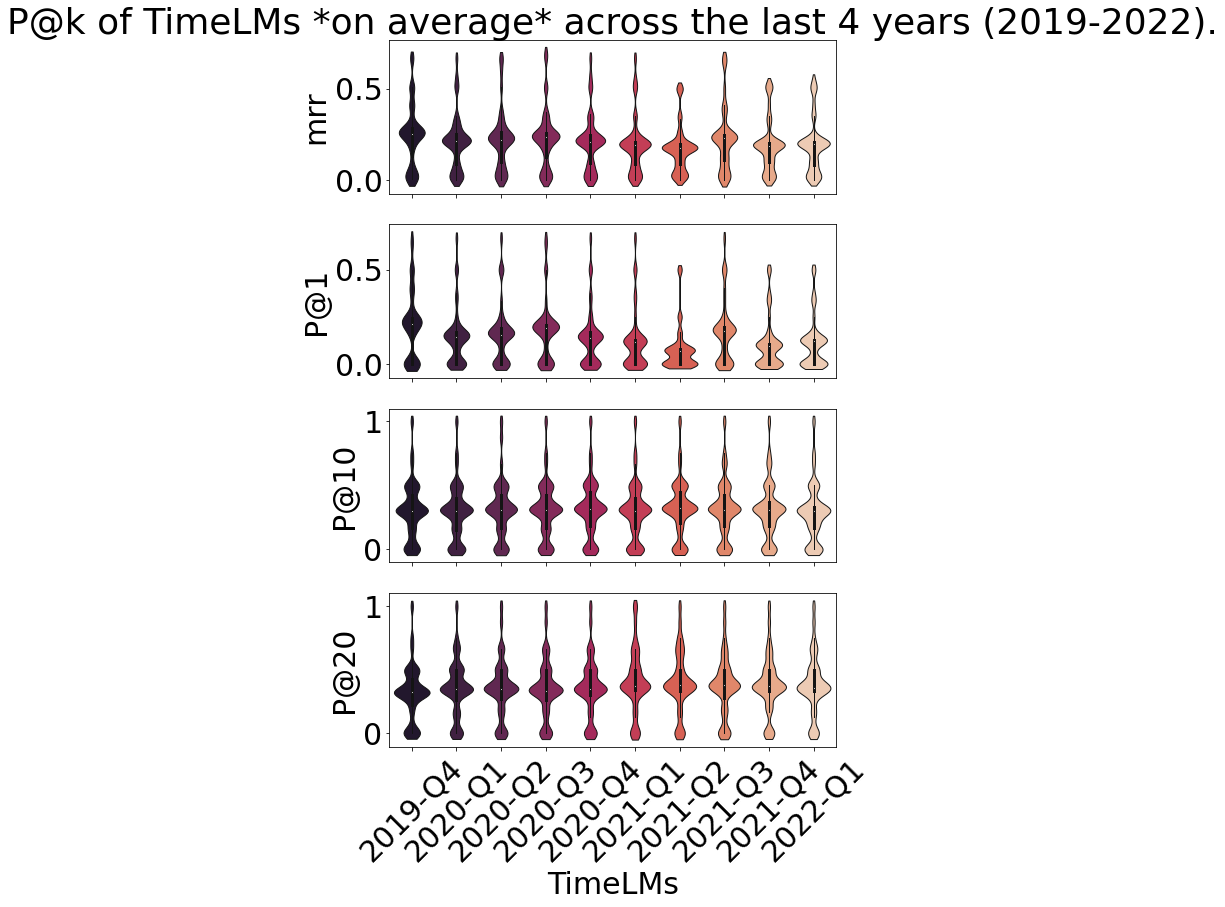

In [225]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1, figsize=(8, 13), sharex=True)
# sns.set_theme(style="ticks")
sns.violinplot(data=results_df, y='mrr', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax0)
sns.violinplot(data=results_df, y='P@1', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax1)
sns.violinplot(data=results_df, y='P@10', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax2)
sns.violinplot(data=results_df, y='P@20', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax3)
plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax0.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("TimeLMs")
ax0.set_title('P@k of TimeLMs *on average* across the last 4 years (2019-2022).')
plt.savefig('plots/P@k_avg_time_last4years_quarter.png', bbox_inches = 'tight', dpi=500)

In [154]:
# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 7), sharex=True)
# # sns.set_theme(style="ticks")
# # sns.violinplot(data=last_4_years_df, y='P@1', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax1)
# sns.violinplot(data=last_4_years_df, y='P@10', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax1)
# sns.violinplot(data=last_4_years_df, y='P@20', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax2)
# plt.xticks(rotation=45)
# # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# # ax1.set_xlabel("")
# # ax2.set_xlabel("")
# # ax3.set_xlabel("TimeLM")
# # ax1.set_title('P@k of different models *on average* for 2018-2022).')
# # ax1.set_title('')
# for ax in axs:
#     for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#         label.set_fontsize(16)
# plt.rcParams.update({'font.size': 20})
# ax1.set_xlabel("")
# ax2.set_xlabel("")
# ax3.set_xlabel("TimeLM")
# ax1.set_title('P@k of different models *on average* for 2018-2022\n')
# # fig.tight_layout()
# plt.savefig('plots/P@k_avg_time_last5years.png', bbox_inches = 'tight', dpi=500)

In [145]:
results_2_model_df = pd.read_csv(
    os.path.join(RES_DIR, 'timelms_2019-1-1_to_2022-12-31_per_quarter_2019-1-1_to_2022-12-31_per_quarter_single_mask.csv'))

In [146]:
results_2_model_df[['model', 'year', 'P@10', 'MRR']]

,model,year,P@10,MRR
0,cardiffnlp/twitter-roberta-base-2019-90m,2019-Q1,0.3248,0.2812
1,cardiffnlp/twitter-roberta-base-2019-90m,2019-Q2,0.3213,0.2784
2,cardiffnlp/twitter-roberta-base-2019-90m,2019-Q3,0.3225,0.2794
3,cardiffnlp/twitter-roberta-base-2019-90m,2019-Q4,0.3145,0.2728
4,cardiffnlp/twitter-roberta-base-2019-90m,2020-Q1,0.3109,0.2695
5,cardiffnlp/twitter-roberta-base-2019-90m,2020-Q2,0.3022,0.2664
6,cardiffnlp/twitter-roberta-base-2019-90m,2020-Q3,0.3137,0.2756
7,cardiffnlp/twitter-roberta-base-2019-90m,2020-Q4,0.3026,0.2665
8,cardiffnlp/twitter-roberta-base-2019-90m,2021-Q1,0.2830,0.2475
9,cardiffnlp/twitter-roberta-base-2019-90m,2021-Q2,0.2910,0.2505
